#Exploring the Polytechnic Magazine: Frequency Analysis and Named Entity Recognition

The Polytechnic Magazine was the in-house magazine of the [Regent Street Polytechnic](https://westminster-atom.arkivum.net/index.php/rsp), one of the predecessor institutions of the [University of Westminster](https://www.westminster.ac.uk/). Since 2011, a digitised run of more than 1,700 issues of the magazine covering the years 1879 to 1960 has been made available by the [University Archive](http://recordsandarchives.westminster.ac.uk/). This has proved an invaluable resource for academic researchers, family historians and university staff. You can search and read the digitised magazines themselves via the University Archive's [Polytechnic Magazine website](https://polymags.westminster.ac.uk/).

This project aims to complement this resource by opening up computational methods of access to the collection. This notebook uses text extracted from the digitised magazines, to enable some basic frequency analysis of the Polytechnic Magazine corpus. 

For more information on the project and how the text was processed, see the [project website](https://github.com/jakebickford/PolyMags).
Copyright for the Polytechnic Magazine is held by the University of Westminster archive, for further information see the [Polytechnic Magazine website](https://polymags.westminster.ac.uk/). Please note that this is a prototype research project and it may be taken down at any time.



##Preparatory steps

These steps install the necessary Python modules for dealing with text and download the Polytechnic Magazine corpus. You should only need to do this once, but if your session becomes inactive you may need to run the cells again.

In [ ]:
#@title Install modules { display-mode: "form" }
#Installing the python libraries we need to work with the text
#pandas for handling data frames
import pandas as pd

import math

#import nltk
#nltk.download('punkt') 

#import pickle
!pip3 install pickle5
import pickle5 as pickle

import matplotlib

#from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#%matplotlib inline

#!pip install pandas bokeh pyproj

#for providing interactive graphs
!pip install pandas_bokeh
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')

#for managing issue dates
from datetime import datetime

#word clouds
import matplotlib.pyplot as plt
from wordcloud import WordCloud

     |████████████████████████████████| 132 kB 4.1 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219340 sha256=cadb99be60fbdc0984918a12426e87898264c78d040ae3a5d98cc899d2d8e72e
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [ ]:
#@title Download corpus and open as a dataframe { display-mode: "form" }
#installing gdown to enable the notebook to download the corpus file from google drive
! pip install gdown -q
! gdown — id <file_id>
#downloading corpus file from google drive
import gdown
url = "https://drive.google.com/uc?id=1RrOn2iOr-H54K3n9QjMkwiY-sY_Pf2mY"
output = "corpus_8.pkl"
gdown.download(url, output, quiet=False)
#Opening the corpus as a dataframe, this is a data structure in Python that is a bit like a spreadsheet. 
#Each line represents one issue of the Polytechnic magazine. 
#The rows contain metadata such as the date and volume of the issue, as well as extracted text that has been processed in various ways for analysis
with open('corpus_8.pkl', "rb") as fh:
  df = pickle.load(fh)


/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: ` gdown — id <file_id>'


Downloading...
From: https://drive.google.com/uc?id=1RrOn2iOr-H54K3n9QjMkwiY-sY_Pf2mY
To: /content/corpus_8.pkl
509MB [00:06, 77.7MB/s]


##Plotting word counts and word frequencies over time

In [ ]:
#@title Word count, page count and words per page over time { display-mode: "form" }

smoothing = 38 #@param {type:"slider", min:0, max:100, step:1}
Graph = "Word count" #@param ["Word count", "Page count", "Words per page"]
DateRangeTool = "No" #@param ["Yes", "No"]
Date_Range_Tool = False
if DateRangeTool == 'Yes':
  Date_Range_Tool = True
#@markdown Select the graph you would like to display. Smoothing may make it easier to see trends, but too much smoothing will distort the data. Set DateRangeTool to Yes if you would like to be able to filter the graph by a date range, if you prefer an overview, set it to No.


if Graph == 'Word count':
  if smoothing >0:#applies smoothing if selected
    df['Wordcount_smoothed'] = df['Wordcount_tokens'].rolling(window=smoothing).mean()
    df['Wordcount_smoothed'].plot(figsize=(1080, 607),rangetool=Date_Range_Tool) #number of words by date
  else:
    df['Wordcount_tokens'].plot(figsize=(1080, 607),rangetool=Date_Range_Tool) 

if Graph == 'Page count':
  if smoothing >0:#applies smoothing if selected
    df['Pages_smoothed'] = df['Pages'].rolling(window=smoothing).mean()
    df['Pages_smoothed'].plot(figsize=(1080, 607),rangetool=Date_Range_Tool)
  else:
    df['Pages'].plot(figsize=(1080, 607),rangetool=Date_Range_Tool) 

if Graph == 'Words per page':
  if smoothing >0:#applies smoothing if selected
    df['Words_per_page_smoothed'] = df['Words_per_page'].rolling(window=smoothing).mean()
    df['Words_per_page_smoothed'].plot(figsize=(1080, 607),rangetool=Date_Range_Tool)
  else:
    df['Words_per_page'].plot(figsize=(1080, 607),rangetool=Date_Range_Tool)



In [ ]:

#The dataframe already contains a column showing how frequently words appear in each issue. This function will go through the column and search for a keyword, returning the number of times the keyword occurs in each issue.
def getFreq(list, keyword):
    for tup in list:
        if tup[0] == keyword:
            return tup[1]
    # if it's gone through the whole list and not found it return zero
    return 0

#instead of adding 'freq' to existing df we will create a new one this will allow us to easily plot multiple values 
freqDf = pd.DataFrame(index=df.index)#creates new df that is blank except for the index (date) column

#gets search terms from the user
#@title Word frequency over time { display-mode: "form" }
keyword1 = "harriers" #@param {type:"string"}
keyword1 = keyword1.lower()
keyword2 = "fencing" #@param {type:"string"}
keyword2 = keyword2.lower()
keyword3 = "football" #@param {type:"string"}
keyword3 = keyword3.lower()
smoothing = 41 #@param {type:"slider", min:0, max:100, step:1}
DateRangeTool = "No" #@param ["Yes", "No"]
Date_Range_Tool = False
if DateRangeTool == 'Yes':
  Date_Range_Tool = True

#@markdown Enter one or more keywords to display how frequently they occur in the corpus. Note that at present you can only enter one keyword per field (not phrases). Smoothing may make it easier to see trends, but too much smoothing will distort the data. Set DateRangeTool to Yes if you would like to be able to filter the graph by a date range, if you prefer an overview, set it to No.


#applies getFreq function to create new dataframe columns based on the frequncy of the search terms 
def addColumn (keyword):
  freqDf[keyword] = df['Frequent_tokens'].apply(getFreq, args=[keyword])
  if smoothing >0:#applies smoothing if selected
    freqDf[keyword] = freqDf[keyword].rolling(window=smoothing).mean()

#calls the add column function with the keyword entered by the user
if keyword1 != "":
  addColumn(keyword1)
if keyword2 != "":
  addColumn(keyword2)
if keyword3 != "":
  addColumn(keyword3)

#plots results


try:
  freqDf.plot_bokeh(kind="line", figsize=(1080, 607),rangetool=Date_Range_Tool)
except:
  print('Enter at least one keyword')


#Frequncy analysis of the whole corpus

In [ ]:


#@title Download the frequency distribution { display-mode: "form" }
#@markdown You must run this cell before continuing to work with the cells below. It downloads a frequency distribution of the corpus.
#installing gdown to enable the notebook to download the corpus file from google drive
! pip install gdown -q
! gdown — id <file_id>

#downloading corpus file from google drive
import gdown
url = "https://drive.google.com/uc?id=1ltlC0HTF6xhc78U-rs2q8Yqo4irtIzut"
output = "FinalFreqDist.pkl"
gdown.download(url, output, quiet=False)

freq_f = open("FinalFreqDist.pkl", "rb")
fdist = pickle.load(freq_f)
freq_f.close()

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: ` gdown — id <file_id>'


Downloading...
From: https://drive.google.com/uc?id=1ltlC0HTF6xhc78U-rs2q8Yqo4irtIzut
To: /content/FinalFreqDist.pkl
5.49MB [00:00, 104MB/s]


In [ ]:
#@title Check the frequency of individual words { display-mode: "form" }
#@markdown Enter a term to see how frequently it occurs in the corpus. Note that very common 'stop words' such as 'the' or 'and' have been filtered out.
new_words_all = fdist.most_common()
search_term = "god" #@param {type:"string"}
search_term = search_term.lower()#make lower case
counter = 0

import inflect
p = inflect.engine()#this is so the rank is expressed as e.g. 73rd or 1st rather than 73 or 1

found = False
for item in new_words_all:
  counter = counter+1 #counter to determine rank
  if item[0] == search_term:#if item found, write the item name and value in the freq dist to the parameters
    
    searchkey=item[0]
    searchvalue=item[1]
    rank = counter
    print ("The term [",searchkey,"] occurs", searchvalue,"times,","it is the",(p.ordinal(rank)),"most frequent word in the corpus.")
    found = True

if found == False:
  print("That term does not occur in the corpus, remember common 'stop words' such as 'the' have already been filtered out.")

The term [ god ] occurs 20836 times, it is the 73rd most frequent word in the corpus.


In [ ]:
#@title List the words in the corpus, in order of frquency { display-mode: "form" }
#@markdown Enter the number of words you would like to see. For example, to see the top 100 words, enter 100.
TotalWords =  50#@param {type:"integer"}
#@markdown To remove the most common words from the list, enter a number in the FilterCommonWords field. For example, entering the number '10' will filter out the 10 most common words. Remember that common 'stop words' such as 'the' or 'and' have already been filtered out.
FilterCommonWords = 10 #@param {type:"integer"}
words_all = (fdist.most_common(TotalWords))
wordsdisplayed = (TotalWords - FilterCommonWords)
print('Displaying',wordsdisplayed,'words.',FilterCommonWords,'words have been filtered from the list.')
trimmedList_all = words_all[FilterCommonWords:]
print(trimmedList_all)

Displaying 40 words. 10 words have been filtered from the list.
[('may', 53831), ('class', 50262), ('would', 49004), ('two', 48107), ('miss', 45325), ('saturday', 43369), ('well', 42985), ('great', 41842), ('year', 41590), ('new', 40420), ('work', 40360), ('next', 40102), ('old', 38647), ('meeting', 37847), ('evening', 37704), ('many', 36829), ('made', 36732), ('day', 36010), ('ist', 35944), ('also', 35697), ('hall', 34941), ('sec', 33909), ('society', 33204), ('place', 33189), ('second', 33026), ('held', 32596), ('team', 31933), ('institute', 31501), ('magazine', 30808), ('london', 29322), ('room', 28915), ('home', 28911), ('see', 28903), ('street', 28603), ('school', 28337), ('men', 28181), ('much', 27868), ('man', 27779), ('every', 26879), ('must', 26147)]


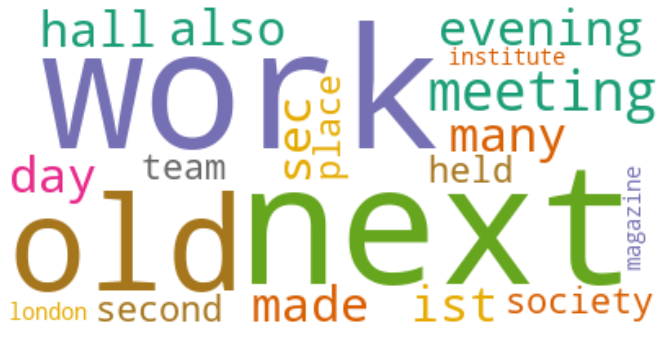

In [ ]:
#@title Display a word cloud of the most frequent words from the corpus. { display-mode: "form" }
#@markdown Word clouds can be a good way to get a quick sense of the frequency of words in a text. This word cloud will be based on the frequency list you generated above. Note that if you have filtered out common words using the cell above, this filter will also be applied to your word cloud.


plt.rcParams['figure.figsize'] = [16, 6]


wordcloud = WordCloud(background_color="white", colormap="Dark2").generate_from_frequencies(dict(trimmedList_all))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


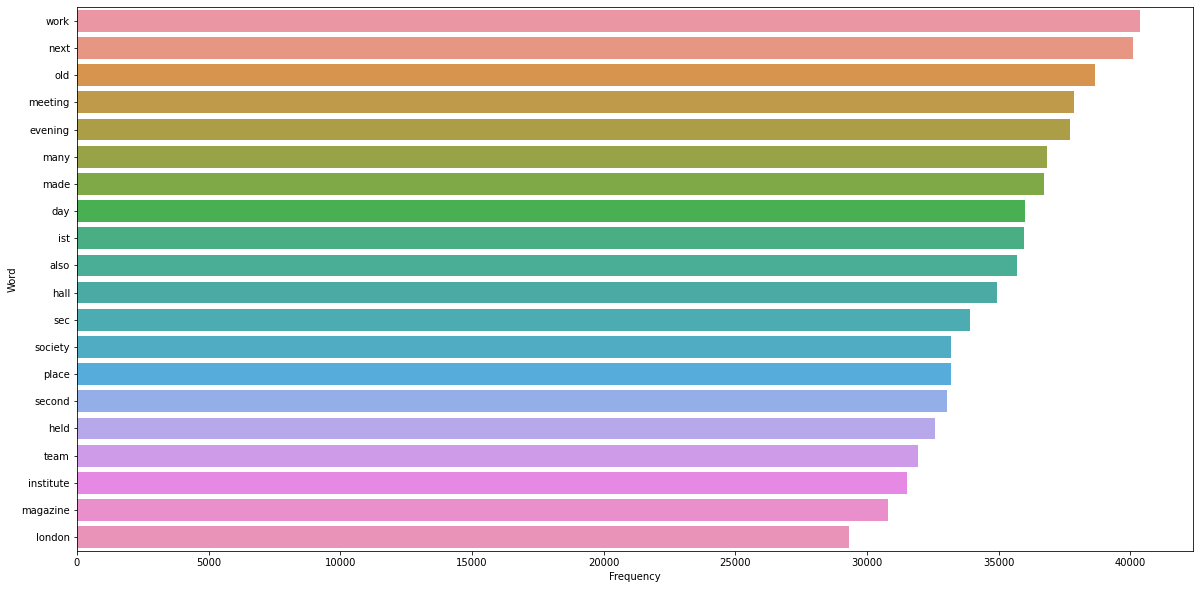

In [ ]:
#@title Frequency bar chart { display-mode: "form" }
#@markdown However, word clouds are not very precise, so it might be more useful to look at a bar chart. This bar chart will be based on the frequency list you generated above. Note that the bar chart might be slower to generate than the word cloud, and you are not able to display more than 1800 words in this chart. If you have more than 1800 words selected, you can go back to the third cell in this section and change your selection.
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
df_freq = pd.DataFrame(trimmedList_all, columns =['Word', 'Frequency'])

if wordsdisplayed > 1800:
  print('You have selected more than 1800 words, this is more than this chart can display. Please go back to the third cell in this section and select a smaller number of words.')
else:
  #sets size of graph based on amount of words to be displayed
  fig_sizey = 0.5 * (wordsdisplayed)
  fig_sizex = 20

  plt.figure(figsize=(fig_sizex,fig_sizey))
  sns.barplot(x = "Frequency", y = "Word", data = df_freq)
  plt.show()

#Looking at an individual magazine in more detail

In [ ]:
#@title Select an issue to work with { display-mode: "form" }
IssueDate =  "1914-09-01" #@param [["1879-06-01", "1879-07-01", "1879-07-01", "1879-08-01", "1879-11-01", "1879-12-01", "1880-01-01", "1880-02-01", "1880-03-01", "1880-04-01", "1880-05-01", "1880-06-01", "1880-07-01", "1880-08-01", "1880-09-01", "1880-10-01", "1880-11-01", "1880-12-01", "1881-01-01", "1881-02-01", "1881-03-01", "1881-04-01", "1881-05-01", "1881-06-01", "1881-07-01", "1881-08-01", "1881-09-01", "1881-10-01", "1881-11-01", "1881-12-01", "1882-01-01", "1882-02-01", "1882-03-01", "1882-04-01", "1882-05-01", "1882-06-01", "1882-07-01", "1882-08-01", "1882-09-01", "1882-10-01", "1882-11-01", "1882-12-01", "1883-02-01", "1883-02-01", "1883-03-01", "1883-04-01", "1883-05-01", "1883-06-01", "1883-07-01", "1883-08-01", "1883-09-01", "1883-10-01", "1883-11-01", "1883-12-01", "1884-01-01", "1884-02-01", "1884-03-01", "1884-04-01", "1884-05-01", "1884-06-01", "1884-07-01", "1884-08-01", "1884-09-01", "1884-09-27", "1884-10-04", "1884-10-11", "1884-10-18", "1884-10-25", "1884-11-01", "1884-11-08", "1884-11-15", "1884-11-22", "1884-11-29", "1884-12-06", "1884-12-13", "1884-12-20", "1884-12-27", "1885-01-03", "1885-01-10", "1885-01-17", "1885-01-24", "1885-01-31", "1885-02-07", "1885-02-14", "1885-02-21", "1885-02-28", "1885-03-07", "1885-03-14", "1885-03-21", "1885-03-28", "1885-04-04", "1885-04-11", "1885-04-18", "1885-04-25", "1885-05-02", "1885-05-09", "1885-05-16", "1885-05-23", "1885-05-30", "1885-06-06", "1885-06-13", "1885-06-20", "1885-06-27", "1885-07-04", "1885-07-11", "1885-07-18", "1885-07-25", "1885-08-01", "1885-08-08", "1885-08-15", "1885-08-22", "1885-08-29", "1885-09-05", "1885-09-12", "1885-09-19", "1885-09-26", "1885-10-03", "1885-10-10", "1885-10-17", "1885-10-24", "1885-10-31", "1885-11-07", "1885-11-14", "1885-11-21", "1885-11-28", "1885-12-05", "1885-12-12", "1885-12-19", "1885-12-26", "1886-01-02", "1886-01-09", "1886-01-16", "1886-01-23", "1886-01-30", "1886-02-06", "1886-02-13", "1886-02-20", "1886-02-27", "1886-03-06", "1886-03-13", "1886-03-20", "1886-03-27", "1886-04-03", "1886-04-10", "1886-04-17", "1886-04-24", "1886-05-01", "1886-05-08", "1886-05-15", "1886-05-22", "1886-05-29", "1886-06-05", "1886-06-12", "1886-06-19", "1886-06-26", "1886-07-03", "1886-07-10", "1886-07-17", "1886-07-24", "1886-07-31", "1886-08-07", "1886-08-14", "1886-08-21", "1886-08-28", "1886-09-04", "1886-09-11", "1886-09-18", "1886-09-25", "1886-10-02", "1886-10-09", "1886-10-16", "1886-10-23", "1886-10-30", "1886-11-06", "1886-11-13", "1886-11-20", "1886-11-27", "1886-12-04", "1886-12-11", "1886-12-18", "1886-12-25", "1887-01-01", "1887-01-08", "1887-01-15", "1887-01-22", "1887-01-29", "1887-02-05", "1887-02-12", "1887-02-19", "1887-02-26", "1887-03-05", "1887-03-12", "1887-03-19", "1887-03-26", "1887-04-02", "1887-04-09", "1887-04-16", "1887-04-23", "1887-04-30", "1887-05-07", "1887-05-14", "1887-05-21", "1887-05-28", "1887-06-04", "1887-06-11", "1887-06-18", "1887-06-25", "1887-07-02", "1887-07-09", "1887-07-16", "1887-07-23", "1887-07-30", "1887-08-06", "1887-08-13", "1887-08-20", "1887-08-27", "1887-09-03", "1887-09-10", "1887-09-17", "1887-09-24", "1887-10-01", "1887-10-08", "1887-10-15", "1887-10-22", "1887-10-29", "1887-11-05", "1887-11-12", "1887-11-19", "1887-11-26", "1887-12-03", "1887-12-10", "1887-12-17", "1887-12-24", "1887-12-31", "1888-01-07", "1888-01-14", "1888-01-21", "1888-01-28", "1888-02-04", "1888-02-16", "1888-02-23", "1888-03-01", "1888-03-08", "1888-03-15", "1888-03-22", "1888-03-29", "1888-04-05", "1888-04-12", "1888-04-19", "1888-04-26", "1888-05-03", "1888-05-10", "1888-05-17", "1888-05-24", "1888-05-31", "1888-06-07", "1888-06-14", "1888-06-21", "1888-06-28", "1888-07-05", "1888-07-12", "1888-07-19", "1888-07-26", "1888-08-02", "1888-08-09", "1888-08-16", "1888-08-23", "1888-08-30", "1888-09-06", "1888-09-13", "1888-09-20", "1888-09-27", "1888-10-04", "1888-10-11", "1888-10-18", "1888-10-25", "1888-11-01", "1888-11-08", "1888-11-15", "1888-11-22", "1888-11-29", "1888-12-06", "1888-12-13", "1888-12-20", "1888-12-27", "1889-01-03", "1889-01-10", "1889-01-17", "1889-01-24", "1889-01-31", "1889-02-07", "1889-02-14", "1889-02-21", "1889-02-28", "1889-03-07", "1889-03-14", "1889-03-21", "1889-03-28", "1889-04-04", "1889-04-11", "1889-04-18", "1889-04-25", "1889-05-02", "1889-05-09", "1889-05-16", "1889-05-23", "1889-05-30", "1889-06-06", "1889-06-13", "1889-06-20", "1889-06-27", "1889-07-04", "1889-07-11", "1889-07-18", "1889-07-25", "1889-08-01", "1889-08-08", "1889-08-15", "1889-08-22", "1889-08-29", "1889-09-05", "1889-09-12", "1889-09-19", "1889-09-26", "1889-10-03", "1889-10-10", "1889-10-17", "1889-10-24", "1889-10-31", "1889-11-07", "1889-11-14", "1889-11-21", "1889-11-28", "1889-12-05", "1889-12-12", "1889-12-19", "1889-12-26", "1890-01-02", "1890-01-09", "1890-01-16", "1890-01-23", "1890-01-30", "1890-02-06", "1890-02-13", "1890-02-20", "1890-02-27", "1890-03-06", "1890-03-13", "1890-03-20", "1890-03-27", "1890-04-03", "1890-04-10", "1890-04-17", "1890-04-24", "1890-05-01", "1890-05-08", "1890-05-15", "1890-05-22", "1890-05-29", "1890-06-05", "1890-06-12", "1890-06-19", "1890-06-26", "1890-07-03", "1890-07-10", "1890-07-17", "1890-07-24", "1890-07-31", "1890-08-07", "1890-08-14", "1890-08-21", "1890-08-28", "1890-09-04", "1890-09-11", "1890-09-18", "1890-09-25", "1890-10-02", "1890-10-09", "1890-10-16", "1890-10-23", "1890-10-30", "1890-11-06", "1890-11-13", "1890-11-20", "1890-11-27", "1890-12-05", "1890-12-12", "1890-12-19", "1890-12-26", "1891-01-02", "1891-01-09", "1891-01-16", "1891-01-23", "1891-01-30", "1891-02-06", "1891-02-13", "1891-02-20", "1891-02-27", "1891-03-06", "1891-03-13", "1891-03-20", "1891-03-27", "1891-04-03", "1891-04-10", "1891-04-17", "1891-04-24", "1891-05-01", "1891-05-08", "1891-05-15", "1891-05-22", "1891-05-29", "1891-05-29", "1891-06-05", "1891-06-12", "1891-06-19", "1891-06-26", "1891-07-01", "1891-07-03", "1891-07-10", "1891-07-17", "1891-07-24", "1891-07-31", "1891-08-07", "1891-08-14", "1891-08-21", "1891-08-28", "1891-09-01", "1891-09-04", "1891-09-11", "1891-09-18", "1891-09-25", "1891-10-01", "1891-10-02", "1891-10-09", "1891-10-16", "1891-10-23", "1891-10-30", "1891-11-01", "1891-11-06", "1891-11-13", "1891-11-20", "1891-11-27", "1891-12-01", "1891-12-04", "1891-12-11", "1891-12-18", "1891-12-25", "1892-01-01", "1892-01-01", "1892-01-08", "1892-01-15", "1892-01-22", "1892-01-29", "1892-02-05", "1892-02-12", "1892-02-19", "1892-02-26", "1892-03-04", "1892-03-11", "1892-03-18", "1892-03-25", "1892-03-31", "1892-04-01", "1892-04-07", "1892-04-14", "1892-04-21", "1892-04-28", "1892-05-01", "1892-05-05", "1892-05-12", "1892-05-19", "1892-05-26", "1892-06-01", "1892-06-02", "1892-06-09", "1892-06-16", "1892-06-23", "1892-06-30", "1892-07-01", "1892-07-07", "1892-07-14", "1892-07-21", "1892-07-28", "1892-08-01", "1892-08-04", "1892-08-11", "1892-08-18", "1892-08-25", "1892-09-01", "1892-09-01", "1892-09-08", "1892-09-15", "1892-09-22", "1892-09-29", "1892-10-01", "1892-10-06", "1892-10-13", "1892-10-20", "1892-10-27", "1892-11-01", "1892-11-03", "1892-11-09", "1892-11-16", "1892-11-23", "1892-11-30", "1892-12-01", "1892-12-07", "1892-12-14", "1892-12-21", "1892-12-28", "1893-01-04", "1893-01-11", "1893-01-18", "1893-01-25", "1893-02-01", "1893-02-08", "1893-02-15", "1893-02-22", "1893-03-01", "1893-03-08", "1893-03-15", "1893-03-22", "1893-03-29", "1893-04-05", "1893-04-12", "1893-04-19", "1893-04-26", "1893-05-03", "1893-05-10", "1893-05-17", "1893-05-24", "1893-05-31", "1893-06-07", "1893-06-14", "1893-06-21", "1893-06-28", "1893-07-05", "1893-07-12", "1893-07-19", "1893-07-26", "1893-08-02", "1893-08-09", "1893-08-16", "1893-08-23", "1893-08-30", "1893-09-06", "1893-09-13", "1893-09-20", "1893-09-27", "1893-10-04", "1893-10-11", "1893-10-18", "1893-10-25", "1893-11-01", "1893-11-08", "1893-11-15", "1893-11-22", "1893-11-29", "1893-12-06", "1893-12-13", "1893-12-20", "1894-01-03", "1894-01-10", "1894-01-17", "1894-01-24", "1894-01-31", "1894-02-07", "1894-02-14", "1894-02-21", "1894-02-28", "1894-03-07", "1894-03-14", "1894-03-21", "1894-03-28", "1894-04-04", "1894-04-11", "1894-04-18", "1894-04-25", "1894-05-02", "1894-05-09", "1894-05-16", "1894-05-23", "1894-05-30", "1894-06-06", "1894-06-13", "1894-06-20", "1894-06-27", "1894-07-04", "1894-07-11", "1894-07-18", "1894-07-25", "1894-08-01", "1894-08-08", "1894-08-15", "1894-08-22", "1894-08-29", "1894-09-05", "1894-09-12", "1894-09-19", "1894-09-26", "1894-10-03", "1894-10-10", "1894-10-17", "1894-10-24", "1894-10-31", "1894-11-07", "1894-11-14", "1894-11-21", "1894-11-28", "1894-12-05", "1894-12-12", "1894-12-19", "1894-12-28", "1895-01-02", "1895-01-09", "1895-01-16", "1895-01-23", "1895-02-06", "1895-02-13", "1895-02-13", "1895-02-20", "1895-02-27", "1895-03-06", "1895-03-13", "1895-03-20", "1895-03-27", "1895-04-03", "1895-04-10", "1895-04-17", "1895-04-24", "1895-05-01", "1895-05-08", "1895-05-15", "1895-05-22", "1895-05-29", "1895-06-05", "1895-06-12", "1895-06-19", "1895-06-26", "1895-07-03", "1895-07-10", "1895-07-17", "1895-07-24", "1895-07-31", "1895-08-07", "1895-08-14", "1895-08-21", "1895-08-28", "1895-09-04", "1895-09-11", "1895-09-18", "1895-09-25", "1895-10-02", "1895-10-09", "1895-10-16", "1895-10-23", "1895-10-30", "1895-11-06", "1895-11-13", "1895-11-20", "1895-11-27", "1895-12-04", "1895-12-11", "1895-12-18", "1895-12-24", "1896-01-01", "1896-01-15", "1896-01-22", "1896-01-29", "1896-02-05", "1896-02-12", "1896-02-19", "1896-02-26", "1896-03-04", "1896-03-11", "1896-03-18", "1896-03-25", "1896-04-01", "1896-04-08", "1896-04-15", "1896-04-22", "1896-04-29", "1896-05-06", "1896-05-13", "1896-05-20", "1896-05-27", "1896-06-03", "1896-06-10", "1896-06-17", "1896-06-24", "1896-07-01", "1896-07-08", "1896-07-15", "1896-07-22", "1896-07-29", "1896-08-01", "1896-08-05", "1896-08-12", "1896-08-19", "1896-08-26", "1896-09-02", "1896-09-09", "1896-09-16", "1896-09-23", "1896-09-30", "1896-10-07", "1896-10-14", "1896-10-21", "1896-10-28", "1896-11-04", "1896-11-11", "1896-11-18", "1896-11-25", "1896-12-02", "1896-12-09", "1896-12-16", "1896-12-22", "1896-12-29", "1896-12-30", "1897-01-06", "1897-01-13", "1897-01-20", "1897-01-27", "1897-02-03", "1897-02-10", "1897-02-17", "1897-02-24", "1897-03-03", "1897-03-10", "1897-03-17", "1897-03-24", "1897-03-31", "1897-04-07", "1897-04-14", "1897-04-21", "1897-04-28", "1897-05-05", "1897-05-12", "1897-05-19", "1897-05-26", "1897-06-02", "1897-06-09", "1897-06-16", "1897-06-23", "1897-06-30", "1897-07-07", "1897-07-14", "1897-07-21", "1897-07-28", "1897-08-04", "1897-08-11", "1897-08-18", "1897-08-25", "1897-09-01", "1897-09-08", "1897-09-15", "1897-09-22", "1897-09-29", "1897-10-06", "1897-10-13", "1897-10-20", "1897-10-27", "1897-11-03", "1897-11-10", "1897-11-17", "1897-11-24", "1897-12-01", "1897-12-08", "1897-12-15", "1897-12-22", "1897-12-29", "1898-01-10", "1898-01-12", "1898-01-19", "1898-01-26", "1898-02-02", "1898-02-09", "1898-02-16", "1898-02-23", "1898-03-02", "1898-03-09", "1898-03-16", "1898-03-23", "1898-03-30", "1898-04-06", "1898-04-13", "1898-04-20", "1898-04-27", "1898-05-04", "1898-05-11", "1898-05-18", "1898-05-25", "1898-06-08", "1898-06-15", "1898-06-22", "1898-06-29", "1898-07-06", "1898-07-13", "1898-07-20", "1898-07-27", "1898-08-10", "1898-08-17", "1898-08-24", "1898-08-31", "1898-09-07", "1898-09-14", "1898-09-21", "1898-09-28", "1898-10-05", "1898-10-12", "1898-10-19", "1898-10-26", "1898-11-02", "1898-11-09", "1898-11-16", "1898-11-23", "1898-11-30", "1898-12-07", "1898-12-14", "1898-12-14", "1898-12-21", "1898-12-21", "1899-01-04", "1899-01-11", "1899-01-18", "1899-01-25", "1899-02-01", "1899-02-08", "1899-02-15", "1899-02-22", "1899-03-01", "1899-03-08", "1899-03-15", "1899-03-22", "1899-03-29", "1899-04-12", "1899-04-19", "1899-04-26", "1899-05-03", "1899-05-10", "1899-05-17", "1899-05-31", "1899-06-07", "1899-06-14", "1899-06-21", "1899-06-28", "1899-07-05", "1899-07-12", "1899-07-19", "1899-07-26", "1899-08-02", "1899-08-16", "1899-08-23", "1899-08-30", "1899-09-06", "1899-09-13", "1899-09-20", "1899-09-27", "1899-10-04", "1899-10-11", "1899-10-18", "1899-10-25", "1899-11-01", "1899-11-08", "1899-11-15", "1899-11-22", "1899-11-29", "1899-12-06", "1899-12-13", "1899-12-20", "1900-01-03", "1900-01-10", "1900-01-17", "1900-01-24", "1900-01-31", "1900-02-07", "1900-02-14", "1900-02-21", "1900-02-28", "1900-03-07", "1900-03-14", "1900-03-21", "1900-03-28", "1900-04-04", "1900-04-11", "1900-04-25", "1900-05-02", "1900-05-09", "1900-05-16", "1900-05-23", "1900-05-30", "1900-06-13", "1900-06-20", "1900-06-27", "1900-07-04", "1900-07-11", "1900-07-18", "1900-07-25", "1900-08-01", "1900-08-15", "1900-08-22", "1900-08-29", "1900-09-05", "1900-09-12", "1900-09-19", "1900-09-26", "1900-10-03", "1900-10-10", "1900-10-17", "1900-10-24", "1900-10-31", "1900-11-07", "1900-11-14", "1900-11-21", "1900-11-28", "1900-12-05", "1900-12-12", "1900-12-19", "1901-01-02", "1901-01-09", "1901-01-16", "1901-01-23", "1901-01-30", "1901-02-06", "1901-02-13", "1901-02-20", "1901-02-27", "1901-03-06", "1901-03-13", "1901-03-20", "1901-03-27", "1901-04-03", "1901-04-17", "1901-04-24", "1901-05-01", "1901-05-08", "1901-05-15", "1901-05-22", "1901-06-05", "1901-06-12", "1901-06-19", "1901-06-26", "1901-07-03", "1901-07-10", "1901-07-17", "1901-07-24", "1901-07-31", "1901-08-14", "1901-08-21", "1901-08-28", "1901-09-04", "1901-09-11", "1901-09-18", "1901-09-25", "1901-10-02", "1901-10-09", "1901-10-16", "1901-10-23", "1901-10-30", "1901-11-06", "1901-11-13", "1901-11-20", "1901-11-27", "1901-12-04", "1901-12-11", "1901-12-17", "1901-12-18", "1902-01-01", "1902-01-08", "1902-01-15", "1902-01-22", "1902-01-29", "1902-02-05", "1902-02-12", "1902-02-19", "1902-02-26", "1902-03-05", "1902-03-12", "1902-03-19", "1902-03-26", "1902-04-09", "1902-04-16", "1902-04-23", "1902-04-30", "1902-05-07", "1902-05-14", "1902-05-28", "1902-06-04", "1902-06-11", "1902-06-18", "1902-06-25", "1902-07-02", "1902-07-09", "1902-07-16", "1902-07-23", "1902-07-30", "1902-08-13", "1902-08-20", "1902-08-27", "1902-09-03", "1902-09-10", "1902-09-17", "1902-09-24", "1902-10-01", "1902-10-08", "1902-10-15", "1902-10-22", "1902-10-29", "1902-11-05", "1902-11-12", "1902-11-19", "1902-11-26", "1902-12-03", "1902-12-10", "1902-12-17", "1902-12-31", "1903-01-07", "1903-01-14", "1903-01-28", "1903-02-04", "1903-02-11", "1903-02-18", "1903-02-25", "1903-03-01", "1903-04-01", "1903-05-01", "1903-06-01", "1903-07-01", "1903-08-01", "1903-09-01", "1903-10-01", "1903-11-01", "1903-12-01", "1904-01-01", "1904-01-01", "1904-01-01", "1904-02-01", "1904-03-01", "1904-04-01", "1904-05-01", "1904-06-01", "1904-07-01", "1904-08-01", "1904-09-01", "1904-10-01", "1904-11-01", "1904-12-01", "1905-01-01", "1905-01-01", "1905-01-01", "1905-01-01", "1905-01-01", "1905-01-01", "1905-02-01", "1905-03-01", "1905-04-01", "1905-05-01", "1905-06-01", "1905-07-01", "1905-08-01", "1905-09-01", "1905-10-01", "1905-11-01", "1905-12-01", "1906-01-01", "1906-02-01", "1906-03-01", "1906-04-01", "1906-05-01", "1906-06-01", "1906-07-01", "1906-08-01", "1906-09-01", "1906-10-01", "1906-11-01", "1906-12-01", "1907-01-01", "1907-02-01", "1907-03-01", "1907-04-01", "1907-05-01", "1907-06-01", "1907-07-01", "1907-08-01", "1907-09-01", "1907-10-01", "1907-11-01", "1907-12-01", "1908-01-01", "1908-02-01", "1908-03-01", "1908-04-01", "1908-05-01", "1908-06-01", "1908-07-01", "1908-08-01", "1908-09-01", "1908-10-01", "1908-11-01", "1908-12-01", "1909-01-01", "1909-02-01", "1909-03-01", "1909-04-01", "1909-05-01", "1909-06-01", "1909-07-01", "1909-08-01", "1909-09-01", "1909-10-01", "1909-11-01", "1909-12-01", "1910-01-01", "1910-02-01", "1910-03-01", "1910-04-01", "1910-05-01", "1910-06-01", "1910-07-01", "1910-08-01", "1910-09-01", "1910-10-01", "1910-11-01", "1910-12-01", "1911-01-01", "1911-02-01", "1911-03-01", "1911-04-01", "1911-05-01", "1911-06-01", "1911-07-01", "1911-08-01", "1911-09-01", "1911-10-01", "1911-11-01", "1911-12-01", "1912-01-01", "1912-02-01", "1912-03-01", "1912-04-01", "1912-05-01", "1912-06-01", "1912-07-01", "1912-08-01", "1912-09-01", "1912-10-01", "1912-11-01", "1912-12-01", "1913-01-01", "1913-02-01", "1913-03-01", "1913-04-01", "1913-05-01", "1913-06-01", "1913-07-01", "1913-08-01", "1913-09-01", "1913-10-01", "1913-11-01", "1913-12-01", "1914-01-01", "1914-02-01", "1914-03-01", "1914-04-01", "1914-05-01", "1914-06-01", "1914-07-01", "1914-08-01", "1914-09-01", "1914-10-01", "1914-11-01", "1914-12-01", "1915-01-01", "1915-02-01", "1915-03-01", "1915-04-01", "1915-05-01", "1915-06-01", "1915-07-01", "1915-08-01", "1915-09-01", "1915-10-01", "1915-11-01", "1915-12-01", "1916-01-01", "1916-02-01", "1916-03-01", "1916-04-01", "1916-05-01", "1916-06-01", "1916-07-01", "1916-08-01", "1916-09-01", "1916-10-01", "1916-11-01", "1916-12-01", "1917-01-01", "1917-02-01", "1917-03-01", "1917-04-01", "1917-05-01", "1917-06-01", "1917-07-01", "1917-08-01", "1917-09-01", "1917-10-01", "1917-11-01", "1917-12-01", "1918-01-01", "1918-02-01", "1918-03-01", "1918-04-01", "1918-05-01", "1918-06-01", "1918-07-01", "1918-08-01", "1918-09-01", "1918-10-01", "1918-11-01", "1918-12-01", "1919-01-01", "1919-02-01", "1919-03-01", "1919-04-01", "1919-05-01", "1919-06-01", "1919-07-01", "1919-08-01", "1919-09-01", "1919-10-01", "1919-11-01", "1919-12-01", "1920-01-01", "1920-02-01", "1920-03-01", "1920-04-01", "1920-05-01", "1920-06-01", "1920-07-01", "1920-08-01", "1920-09-01", "1920-10-01", "1920-11-01", "1920-12-01", "1921-01-01", "1921-02-01", "1921-03-01", "1921-04-01", "1921-05-01", "1921-06-01", "1921-07-01", "1921-08-01", "1921-09-01", "1921-10-01", "1921-11-01", "1921-12-01", "1922-01-01", "1922-02-01", "1922-03-01", "1922-04-01", "1922-05-01", "1922-06-01", "1922-07-01", "1922-08-01", "1922-09-01", "1922-10-01", "1922-11-01", "1922-12-01", "1923-01-01", "1923-02-01", "1923-03-01", "1923-04-01", "1923-05-01", "1923-06-01", "1923-07-01", "1923-08-01", "1923-09-01", "1923-10-01", "1923-11-01", "1923-12-01", "1924-01-01", "1924-02-01", "1924-03-01", "1924-04-01", "1924-05-01", "1924-06-01", "1924-07-01", "1924-08-01", "1924-09-01", "1924-10-01", "1924-11-01", "1924-12-01", "1925-01-01", "1925-02-01", "1925-03-01", "1925-04-01", "1925-05-01", "1925-06-01", "1925-07-01", "1925-08-01", "1925-09-01", "1925-10-01", "1925-11-01", "1925-12-01", "1926-01-01", "1926-02-01", "1926-03-01", "1926-04-01", "1926-05-01", "1926-06-01", "1926-07-01", "1926-08-01", "1926-09-01", "1926-10-01", "1926-11-01", "1926-12-01", "1927-01-01", "1927-02-01", "1927-03-01", "1927-04-01", "1927-05-01", "1927-06-01", "1927-07-01", "1927-08-01", "1927-09-01", "1927-10-01", "1927-11-01", "1927-12-01", "1928-01-01", "1928-02-01", "1928-03-01", "1928-04-01", "1928-05-01", "1928-06-01", "1928-07-01", "1928-08-01", "1928-09-01", "1928-10-01", "1928-11-01", "1928-12-01", "1929-01-01", "1929-02-01", "1929-03-01", "1929-04-01", "1929-05-01", "1929-06-01", "1929-07-01", "1929-08-01", "1929-09-01", "1929-10-01", "1929-11-01", "1929-12-01", "1930-01-01", "1930-02-01", "1930-03-01", "1930-04-01", "1930-05-01", "1930-06-01", "1930-07-01", "1930-08-01", "1930-09-01", "1930-10-01", "1930-11-01", "1930-12-01", "1931-01-01", "1931-02-01", "1931-03-01", "1931-04-01", "1931-05-01", "1931-06-01", "1931-07-01", "1931-08-01", "1931-09-01", "1931-10-01", "1931-11-01", "1931-12-01", "1932-01-01", "1932-02-01", "1932-03-01", "1932-04-01", "1932-05-01", "1932-06-01", "1932-07-01", "1932-08-01", "1932-09-01", "1932-10-01", "1932-11-01", "1932-12-01", "1933-01-01", "1933-02-01", "1933-03-01", "1933-04-01", "1933-05-01", "1933-06-01", "1933-07-01", "1933-08-01", "1933-09-01", "1933-10-01", "1933-11-01", "1933-12-01", "1934-01-01", "1934-02-01", "1934-03-01", "1934-04-01", "1934-05-01", "1934-06-01", "1934-07-01", "1934-08-01", "1934-09-01", "1934-10-01", "1934-11-01", "1934-12-01", "1935-01-01", "1935-02-01", "1935-03-01", "1935-04-01", "1935-05-01", "1935-06-01", "1935-07-01", "1935-08-01", "1935-09-01", "1935-10-01", "1935-11-01", "1935-12-01", "1936-01-01", "1936-02-01", "1936-03-01", "1936-04-01", "1936-05-01", "1936-06-01", "1936-07-01", "1936-08-01", "1936-09-01", "1936-10-01", "1936-11-01", "1936-12-01", "1937-01-01", "1937-02-01", "1937-03-01", "1937-04-01", "1937-05-01", "1937-06-01", "1937-07-01", "1937-08-01", "1937-09-01", "1937-10-01", "1937-11-01", "1937-12-01", "1938-01-01", "1938-02-01", "1938-03-01", "1938-04-01", "1938-05-01", "1938-06-01", "1938-07-01", "1938-08-01", "1938-09-01", "1938-10-01", "1938-11-01", "1938-12-01", "1939-01-01", "1939-02-01", "1939-03-01", "1939-04-01", "1939-05-01", "1939-06-01", "1939-07-01", "1939-08-01", "1939-09-01", "1939-10-01", "1939-11-01", "1939-12-01", "1940-01-01", "1940-02-01", "1940-03-01", "1940-04-01", "1940-05-01", "1940-06-01", "1940-07-01", "1940-08-01", "1940-09-01", "1940-10-01", "1940-11-01", "1940-12-01", "1941-01-01", "1941-02-01", "1941-03-01", "1941-04-01", "1941-05-01", "1941-06-01", "1941-07-01", "1941-08-01", "1941-09-01", "1941-10-01", "1941-11-01", "1941-12-01", "1942-01-01", "1942-02-01", "1942-03-01", "1942-04-01", "1942-05-01", "1942-06-01", "1942-07-01", "1942-08-01", "1942-09-01", "1942-10-01", "1942-11-01", "1942-12-01", "1943-01-01", "1943-02-01", "1943-03-01", "1943-04-01", "1943-05-01", "1943-06-01", "1943-07-01", "1943-08-01", "1943-09-01", "1943-10-01", "1943-11-01", "1943-12-01", "1944-01-01", "1944-02-01", "1944-03-01", "1944-04-01", "1944-05-01", "1944-06-01", "1944-07-01", "1944-08-01", "1944-09-01", "1944-10-01", "1944-11-01", "1944-12-01", "1945-01-01", "1945-02-01", "1945-03-01", "1945-04-01", "1945-05-01", "1945-06-01", "1945-07-01", "1945-08-01", "1945-09-01", "1945-10-01", "1945-11-01", "1945-12-01", "1946-01-01", "1946-02-01", "1946-03-01", "1946-04-01", "1946-05-01", "1946-06-01", "1946-07-01", "1946-08-01", "1946-09-01", "1946-10-01", "1946-11-01", "1946-12-01", "1947-01-01", "1947-02-01", "1947-03-01", "1947-04-01", "1947-05-01", "1947-06-01", "1947-07-01", "1947-08-01", "1947-09-01", "1947-10-01", "1947-11-01", "1947-12-01", "1948-01-01", "1948-02-01", "1948-03-01", "1948-04-01", "1948-05-01", "1948-06-01", "1948-07-01", "1948-08-01", "1948-09-01", "1948-10-01", "1948-11-01", "1948-12-01", "1949-01-01", "1949-02-01", "1949-03-01", "1949-04-01", "1949-05-01", "1949-06-01", "1949-07-01", "1949-08-01", "1949-09-01", "1949-10-01", "1949-11-01", "1949-12-01", "1950-01-01", "1950-02-01", "1950-03-01", "1950-04-01", "1950-05-01", "1950-06-01", "1950-07-01", "1950-08-01", "1950-09-01", "1950-10-01", "1950-11-01", "1950-12-01", "1951-01-01", "1951-02-01", "1951-03-01", "1951-04-01", "1951-05-01", "1951-06-01", "1951-07-01", "1951-08-01", "1951-09-01", "1951-10-01", "1951-11-01", "1951-12-01", "1952-01-01", "1952-02-01", "1952-03-01", "1952-04-01", "1952-05-01", "1952-06-01", "1952-07-01", "1952-08-01", "1952-09-01", "1952-10-01", "1952-11-01", "1952-12-01", "1953-01-01", "1953-02-01", "1953-03-01", "1953-04-01", "1953-05-01", "1953-06-01", "1953-07-01", "1953-08-01", "1953-09-01", "1953-10-01", "1953-11-01", "1953-12-01", "1954-01-01", "1954-02-01", "1954-03-01", "1954-04-01", "1954-05-01", "1954-06-01", "1954-07-01", "1954-08-01", "1954-09-01", "1954-10-01", "1954-11-01", "1954-12-01", "1955-01-01", "1955-02-01", "1955-03-01", "1955-04-01", "1955-05-01", "1955-06-01", "1955-07-01", "1955-08-01", "1955-09-01", "1955-10-01", "1955-11-01", "1955-12-01", "1956-01-01", "1956-02-01", "1956-03-01", "1956-04-01", "1956-05-01", "1956-06-01", "1956-07-01", "1956-08-01", "1956-09-01", "1956-10-01", "1956-11-01", "1956-12-01", "1957-01-01", "1957-02-01", "1957-03-01", "1957-04-01", "1957-05-01", "1957-06-01", "1957-07-01", "1957-08-01", "1957-09-01", "1957-10-01", "1957-11-01", "1957-12-01", "1958-01-01", "1958-02-01", "1958-03-01", "1958-04-01", "1958-05-01", "1958-06-01", "1958-07-01", "1958-08-01", "1958-09-01", "1958-10-01", "1958-11-01", "1958-12-01", "1959-01-01", "1959-02-01", "1959-03-01", "1959-04-01", "1959-05-01", "1959-06-01", "1959-07-01", "1959-08-01", "1959-09-01", "1959-10-01", "1959-11-01", "1959-12-01", "1960-01-01", "1960-02-01", "1960-03-01", "1960-04-01", "1960-05-01", "1960-06-01", "1960-07-01", "1960-08-01", "1960-09-01", "1960-10-01", "1960-11-01", "1960-12-01"]
#@markdown Note that early editions of Home Tidings were published monthly and the day of publication is not recorded, for these issues (and for occasional specials) the date has been given as the first day of the month of publication e.g. 1879-06-01 for the March 1879 issue. This has also been applied to the Polytechnic Magazine when it moved from weekly to monthly publication from March 1903.
#convert selected string to date
date_time_str = IssueDate
date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d')

print('You have selected:')
if str(df.at[date_time_obj,'Issue']) =='nan':
  print('An issue of',df.at[date_time_obj,'Type'])
else:
  print('Issue',df.at[date_time_obj,'Issue'],'of Volume',(int(df.at[date_time_obj,'Volume'])),'of the', df.at[date_time_obj,'Type'])
print('This issue was',df.at[date_time_obj,'Pages'],'pages long, and the version in the filtered corpus contains',df.at[date_time_obj,'Wordcount_tokens'],'words.')
polyURL = 'https://polymags.westminster.ac.uk/PDFFiles/'+(df.at[date_time_obj,'Filename'])
print ('You can read the full digitised copy of this issue at', polyURL)

You have selected:
Issue 7 of Volume 54 of the Polytechnic Magazine
This issue was 20 pages long, and the version in the filtered corpus contains 10267 words.
You can read the full digitised copy of this issue at https://polymags.westminster.ac.uk/PDFFiles/HT0540007.pdf


In [ ]:
#@title List the words contained in your selected issue, in order of frequency { display-mode: "form" }
#@markdown Note that if you select a new issue in the cell above, you must run the cell again in order to update the list.

#@markdown Some words, such as 'Polytechnic' may appear near the top of the frequency list for many issues, this might make it hard to compare different issues. If you would like to remove the most common words from the list, enter a number in the MostCommonWords field. For example, entering the number '10' will filter out the 10 most common words. Note that common 'stop words' such as 'the' or 'and' have already been filtered out.
MostCommonWords = 10 #@param {type:"integer"}
words = df.at[date_time_obj,'Frequent_tokens']

trimmedList = words[MostCommonWords:]
print(trimmedList)

[('club', 37), ('science', 37), ('mechanical', 35), ('boys', 34), ('chemistry', 34), ('physics', 33), ('metres', 33), ('street', 32), ('september', 31), ('war', 30), ('polytechnic', 29), ('year', 29), ('art', 29), ('manual', 28), ('may', 27), ('instruction', 27), ('new', 26), ('day', 26), ('team', 26), ('certificates', 26), ('canada', 25), ('london', 24), ('good', 24), ('event', 24), ('seconds', 24), ('ist', 23), ('technical', 23), ('would', 22), ('every', 22), ('great', 22), ('events', 22), ('schools', 22), ('many', 21), ('french', 21), ('race', 21), ('commercial', 21), ('two', 20), ('points', 20), ('sports', 20), ('rifle', 19), ('german', 19), ('modern', 19), ('magazine', 18), ('men', 18), ('could', 18), ('july', 18), ('first', 18), ('certificate', 18), ('country', 17), ('must', 17), ('work', 17), ('help', 17), ('saturday', 17), ('pray', 17), ('relay', 17), ('geometry', 17), ('flat', 17), ('languages', 17), ('hogg', 16), ('years', 16), ('made', 16), ('need', 16), ('fund', 16), ('plac

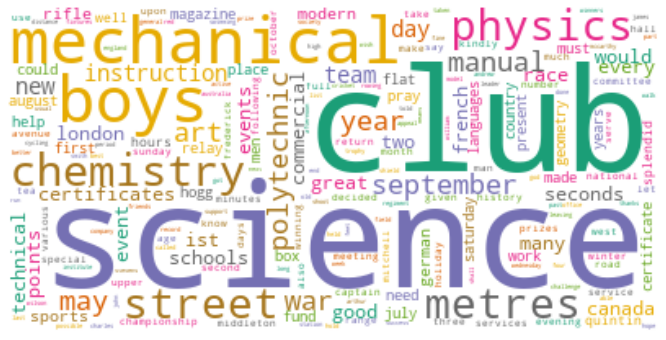

In [ ]:
#@title Display a word cloud of the most frequent words from your selected issue. { display-mode: "form" }
#@markdown Note that if you have filtered out common words using the cell above, this filter will also be applied to your word cloud.


plt.rcParams['figure.figsize'] = [16, 6]


wordcloud = WordCloud(background_color="white", colormap="Dark2").generate_from_frequencies(dict(trimmedList))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [ ]:
#@title Frequency bar chart { display-mode: "form" }
#@markdown However, word clouds are not very precise, so it might be more useful to look at a bar chart. This bar chart will display up to 1800 terms from your selected issue. Note that the bar chart might be slower to generate than the word cloud.
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

trimmedList = words[MostCommonWords:]
trimmedListBar = trimmedList[0:1799]
trimmedlistbarlen = len(trimmedListBar)

df_freq_bar = pd.DataFrame(trimmedListBar, columns =['Word', 'Frequency'])

#sets size of graph based on amount of words to be displayed
fig_sizey = 0.5 * (trimmedlistbarlen)
fig_sizex = 20

plt.figure(figsize=(fig_sizex,fig_sizey))
sns.barplot(x = "Frequency", y = "Word", data = df_freq_bar)
plt.show()

##Named entity recognition

In [ ]:
#@title Identify and tag people and places in your selected issue { display-mode: "form" }
#@markdown This section uses [Named Entity Recognition](https://spacy.io/usage/linguistic-features) to identify 
#@markdown entities such as people and places within your chosen issue. When you run this cell, the text of the issue
#@markdown will be shown below with coloured tags to inticate entites.
#@markdown Note that you must have selected an issue in the section above to run this section.
FileContent = (df.at[date_time_obj,'Text'])

import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

doc = nlp(FileContent)
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ORG"], "colors": colors}
displacy.render(doc, style="ent", jupyter=True)

In [ ]:
#@title List all identified entities { display-mode: "form" }
#@markdown Running this cell will display a list of all the named entities that have been identified in your issue.
print(listofents)

[['TIDINGS', 'ORG'], ['NEWS', 'ORG'], ['1', 'CARDINAL'], ['JUNE, 1879', 'DATE'], ['2p', 'CARDINAL'], ['first', 'ORDINAL'], ['about three weeks ago', 'DATE'], ['four', 'CARDINAL'], ['Farmer', 'PERSON'], ['Ted Ravani', 'PERSON'], ['half', 'CARDINAL'], ['the\nwhole Institute', 'ORG'], ['one day', 'DATE'], ['Bob Mitchell', 'PERSON'], ['Samaritan', 'PERSON'], ['Glasgow', 'GPE'], ['half', 'CARDINAL'], ['second', 'ORDINAL'], ['Commitiee', 'PERSON'], ['One', 'CARDINAL'], ['Institute', 'ORG'], ['Bill Green', 'PERSON'], ['Afghanistan', 'GPE'], ['Lindsey', 'PERSON'], ['Demerara', 'PERSON'], ['Sandy', 'PERSON'], ['half', 'CARDINAL'], ['dozen', 'CARDINAL'], ['Limes', 'ORG'], ['Ian', 'PERSON'], ['Hanover', 'GPE'], ['Pelham', 'PERSON'], ['Drew', 'PERSON'], ['Martin', 'PERSON'], ['Bill Finch', 'PERSON'], ['French', 'NORP'], ['Shorthand Classes', 'ORG'], ['Horton', 'ORG'], ['2', 'CARDINAL'], ['Richmond Terrace', 'FAC'], ['Tt', 'PERSON'], ['P', 'PERSON'], ['winter', 'DATE'], ['Kinnaird', 'PERSON'], ['ni

In [ ]:
#@title Export  filtered list of entities { display-mode: "form" }
#@markdown This cell will generate a list of of the entities based on your selected dropdown. 
#@markdown You can use this list with other applications, for example you could try exporting a list of places and 
#@markdown plotting them on a [Google map](https://support.google.com/mymaps/answer/3024836?hl=en&co=GENIE.Platform%3DDesktop). 

#@markdown For example [this map](https://www.google.com/maps/d/edit?mid=1PmvHkR4_DW5GrhtPGgkubWQRv_F5qamF&usp=sharing)
#@markdown was generated using all the places found in the first issue of Home Tidings. Note that this process is likely to generate lot of false positives,
#@markdown as it depends on both the named entities being correct, and then them correctly being identified by google maps.
#@markdown For example in this map, the place entity 'Richmond' was marked as being Richmond, Virginia, when it probably should refer to Richmond in South West London.
#@markdown It is therefore advisable to manually verify the list before using it.

NEtype = "Places" #@param ["Places", "People", "Organisations", "All"]

FileContent = (df.at[date_time_obj,'Text'])
#https://spacy.io/usage/linguistic-features#named-entities
nlp = spacy.load("en_core_web_sm")
#do nlp on selected text
doc = nlp(FileContent)
#create list of entities and lables
listofents =[]
for ent in doc.ents:
    listofents.append([ent.text, ent.label_])

#filter list so it only includes selected entity type

listOfNEs = []

#geographical locations
if NEtype == 'Places':
  for item in listofents:
    if item[1] == 'LOC':
      listOfNEs.append(item)
    elif item[1] =='GPE':
      listOfNEs.append(item)
elif NEtype == 'People':
  for item in listofents:
    if item[1] == 'PERSON':
      listOfNEs.append(item)
elif NEtype == 'Organisations':
  for item in listofents:
    if item[1] == 'ORG':
      listOfNEs.append(item)
else:
  for item in listofents:
    listOfNEs.append(item)

#display only list
for item in listOfNEs:
  print (item[0])

Glasgow
Afghanistan
Hanover
Canada
Niagara
Toronto
Atlantic
England
Wakenaam
York Place
London
Botley
London
Bath Terrace
E.C.
St. John Street
Victoria
Aberdeen
Aberdeen
Paris
Paris
Paris
Paris
Paris
Soprano
Martin
B.M.
Qnd Do.
8rd Do.
Qnd Do.
Qnd Do.
W. Day
D. Sloman
L’Artilleur
Penelope
Britannia
the Prince of Wales
W. Ash
A. Woodgate
W. Woodgate
Burgess
Sea
England
Ireland
London
London
Natal
Port-Narat
England
Natal
Natal
Rorke
Zululand
Buffaloe
Natal
Zululand
Isandula
Rorke
Weekley
Rorke
Rorke
Scotland
Maine
Richmond
Germany
France
Archie
Atlantic
&e
Eddington
Shorthand
Shorthand
Shorthand
HowaRrta
Bay
Dykes
Rome
Holy Writ
Adam
Noah
Genesis
Abraham
Ishmael
earth
Noah
Chaldea
Egypt
Euphrates
Nile
earth
Egypt
Sinai
the
sea
Chaldea
Egypt
Jehovah
Noah
Abraham
Noah
London
London
Niagara
us
Egypt
Canaan
Chaldean
Canaan
Aram
Canaan
Chaldean
Belik
Euphrates
Egypt
England
Euphrates
Damascus
Mayflower
England
Atlantic
England
England
Columbus
America
Columbus
America
Columbus
America
the We